# Training Deep Neural Networks <a class="anchor" id="top"></a>

This notebook was written by following the textbook of  Aurélien Géron's *Hands-On Machine Learning with Scikit-Learn and TensorFlow*, along with associated datasets ([Link to Github Repo](https://github.com/ageron/handson-ml/)). The contents in this notebook are my notes from reading the textbook.

### Notebook by Justin Bandoro

For complex problems, such as detecting hundreds of types of objects in high-resolution images, you may need to train a deeper DNN with up to 10 layers, each containing hundreds of neurons, connected by hundred of thousands of connections. There are a few problems that arise:

1. *Vanishing gradient* problem (or exploding gradient) that affects deep neural networks and makes lower layers hard to train.
2. Training would be quite slow with such a large network.
3. A model with millions of parameters would risk overfitting the training set.

We will address all of the above with techniques to solve them.

In [1]:
# Load modules
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
from IPython.display import display
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as sio
from matplotlib import cm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

### Viewing TensorBoard in Jupyter
Quick script to view our graphs in the notebook.

In [2]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = b"<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:350px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:800px;height:400px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

## 1. Vanishing/Exploding Gradients Problem <a class="anchor" id="vanishing"></a>

The backpropagation method works by going from the output layer to the input layer, propagating the error gradient on the way. When the algorithm  has computed the gradient of the cost function with regards to each parameter in the network, it uses the gradients to update each parameter with a Gradient Descent step.

As the algorithm proceeds backwards down all of the layers, the gradients get smaller and smaller. As a result, the updating of lower layers can leave the connection weights virtually unchanged, and training never converges to a good solution. This is called **vanishing gradients** problem, and in some cases the opposite can happen: the gradients can grow larger and larger and layers get insanely large weight updates and the algorithm diverges (**exploding gradients**). The latter is encountered in recurrent neural networks. This was one of the reasons that DNNs were abandonned in the 1990s.

It was found in 2010 that the combination of the popular logistic sigmoid activation function and the weight initialization technique of a normal distribution with a mean of 0 and standard deviation of 1. It was found that the variance of outputs of each layer was greater than the variance of its inputs, and thus going forward the the variance keeps increasing after each layer until the activation function saturates at the top layers. Looking at the logistic activation function below we see that when the inputs become large (negative or positive) the function satures at 0 or 1 with a derivative close to 0. Thus when backpropagtion kicks in there is virtually no gradient to propagate back through the network. The gradient that is propagated backwards is diluted after each layer and there is nothing left in the lower layers.

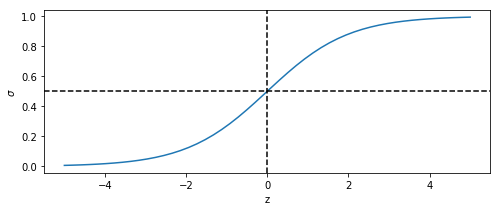

In [4]:
# Plot sigmoid function
z     = np.linspace(-5,5,50)
sigma = 1./(1+np.exp(-z))
fig,ax= plt.subplots(1,figsize=[8,3])
ax.plot(z,sigma);ax.set_xlabel('z');ax.set_ylabel(r'$\sigma$')
ax.axvline([0],color='k',ls='--');ax.axhline([0.5],color='k',ls='--')

### Xavier and He Initialization
The problem is that the signal needs to be able to flow properly in both directions: in the forward direction when making predictions, and in the reverse when backpropagating gradients. We don't want the signal to vanish or explode/saturate. For this to happen the variance of the outputs needs to be equal to the variance of the inputs, and the gradients need to have equal variance before and after flowing through the layer in the reverse direction.

The weights must be initialized randomly where $n_{inputs}$ and $n_{ouputs}$ are the number of input and ouput connections for the layer whose weights are being initialized (called fan-in and fan-out).

> Normal distribution with mean 0 and standard deviation $\sigma = \sqrt{ \frac{2}{n_{inputs}+n_{outputs}}  }$

> Uniform distribution between $-r$ and $+r$ with $r=\sqrt{ \frac{6}{n_{inputs}+n_{outputs}}  }$

When the number of input connections is roughly equal to the number of output connections, the above simplifies to $\sigma=1/\sqrt{n_{inputs}}$ or $r=\sqrt{3}/\sqrt{n_{inputs}}$. Below are the known initializations for different activation functions:

| Activation function  |Uniform distribution | Normal distribution   |
|---|---|---|
|Logistic       | $r=\sqrt{ \frac{6}{n_{inputs}+n_{outputs}}  }$  | $\sigma = \sqrt{ \frac{2}{n_{inputs}+n_{outputs}}  }$  |
|Hyperbolic tan | $r=4\sqrt{ \frac{6}{n_{inputs}+n_{outputs}}  }$  | $\sigma = 4\sqrt{ \frac{2}{n_{inputs}+n_{outputs}}  }$  |
|ReLU           | $r=\sqrt{2} \sqrt{ \frac{6}{n_{inputs}+n_{outputs}}  }$  |$\sigma = \sqrt{2}\sqrt{ \frac{2}{n_{inputs}+n_{outputs}}  }$   |

By default, the `fully_connected()` function uses logistic uniform distribution. This can be changed by using the `tf.layers.variance_scaling_initializer()`. With the new api, the `dense()` function has `kernel_initializer` paramter. 

In [5]:
import tensorflow as tf
tf.reset_default_graph()
# MNIST type input
n_inputs=28*28
n_hidden1= 300
# Placeholders
X=tf.placeholder(tf.float32,shape=(None,n_inputs),name='X')
# Change intializer
he_init = tf.contrib.layers.variance_scaling_initializer()
hidden1 = tf.layers.dense(X,n_hidden1,activation=tf.nn.relu,
                         kernel_initializer=he_init,name='hidden1')

### Nonsaturating Activation Functions
Since it was known that the brain's neurons use sigmoid shaped activation functions, it was thought they were the best choice for ANNs. However other activation functions behave better in DNNs, with ReLU activation function being a good choice because it does not saturate for positive values.

ReLU activation has problems though, it suffers from *dying* ReLUs during training where some neurons effectively die, meaning they stop outputting anything other than 0. During training, if a neuron's weights get updated such that the weighted sum of the neuron's inputs is negative, it will start outputting 0. When this happens the neuron is unlikely to come back to life as the gradient is 0.

To solve this issue a **Leaky ReLU** can be used where the function is defined as: $ReLU_{\alpha}(z) = \max(\alpha z, z)$. The hyperparameter $\alpha$ determines how much the function leaks, it is the slope of the function for $z<0$, and is typically set to 0.01.

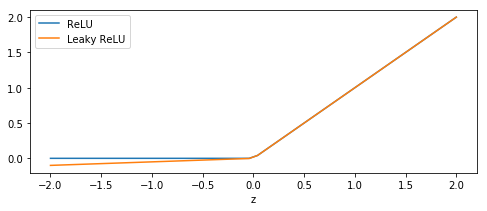

In [11]:
# ReLU vs Leaky ReLU
z     = np.linspace(-2,2,50)
def relu(z):
    return np.maximum(z,0)
def leaky_relu(z,alpha=0.01):
    return np.maximum(z,alpha*z)
fig,ax= plt.subplots(1,figsize=[8,3])
ax.plot(z,relu(z),label='ReLU'); ax.plot(z,leaky_relu(z,0.05),label='Leaky ReLU')
ax.set_xlabel('z'); ax.legend()

The small slope of the leak, ensures that the leaky ReLUs never die; they can go into a long coma, but they have a chance to eventually wake up. The leaky variants always outperformed the ReLU activation function. 

Another activation function called the exponential linear unit (ELU) was found to outperform the ReLU variants in some experiments. It is represented as:

$ELU_\alpha(z) = \left\{
\begin{array}{l,c,l}
      \alpha(\exp(z)-1),& if& z <  0 \\
      z, &if  z \geq  0 \\
\end{array} 
\right.$

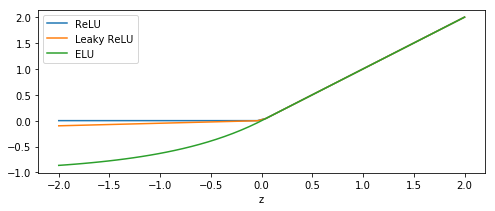

In [12]:
def elu(z,alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

fig,ax= plt.subplots(1,figsize=[8,3])
ax.plot(z,relu(z),label='ReLU'); ax.plot(z,leaky_relu(z,0.05),label='Leaky ReLU')
ax.plot(z,elu(z),label='ELU')
ax.set_xlabel('z'); ax.legend()

Different from the ReLU, the ELU:
1. Has negative values when $z<0$ which allows the unit to have an average output closer to 0. Helps alleivate the vanishing gradient problem. The hyperparameter $\alpha$ defines the value that the ELU function approaches when $z$ is large and negative. It is usually set to 1, but can be tweaked.
2. Has a nonzero gradient for $z<0$, which avoids the dying issue.
3. Is smooth everywhere, including around 0, which helps speed up Gradient Descent as it does not bounce as much around $z=0$.

The disadvantage is that it is slower to compute the activation function (due to the exponential), but this is compensated by faster convergence. 

> Which Activation Function to choose for hidden layers? In general ELU > leaky ReLU > ReLU > tanh > logistic. If runtime needs to be fast then leaky ReLU might be better than ELU. If you don't want to tweak any hyperparameters you can use the default $\alpha$ of 0.01 for leaky ReLU and 1 for ELU. 

Below we show an example on the MNIST data using the ELU activation function with he_initialization. Note that there is an ELU activation function in `tf.nn.elu`.

In [16]:
from tensorflow.examples.tutorials.mnist import input_data
tf.reset_default_graph()

def elu(z,alpha=1,name=None):
    return tf.where(z < 0, alpha*(tf.exp(z) - 1), z,name=name)

# MNIST input data
mnist = input_data.read_data_sets("/tmp/data/")
n_inputs = 28*28 # number of pixels
n_hidden1 = 300; n_hidden2 = 100
n_outputs = 10
# Placeholders for training data
X = tf.placeholder(tf.float32, shape=(None,n_inputs),name='X')
y = tf.placeholder(tf.int64, shape=(None),name='y')
# Change intializer
he_init = tf.contrib.layers.variance_scaling_initializer()
# Neural Network
with tf.name_scope('dnn'):
    hidden1 = tf.layers.dense(X,n_hidden1,name= "hidden1",activation=elu,kernel_initializer=he_init)
    hidden2 = tf.layers.dense(hidden1, n_hidden2, name='hidden2',activation=elu,kernel_initializer=he_init)
    logits  = tf.layers.dense(hidden2, n_outputs, name="outputs")
# Loss Function
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logits)
    loss  = tf.reduce_mean(xentropy,name='loss')
# Minimize Cost Function
eta = 0.01
with tf.name_scope('train'):
    optimizer = tf.train.GradientDescentOptimizer(eta)
    training_op = optimizer.minimize(loss)
# Evaluation
with tf.name_scope('eval'):
    # Find whether the top logit (prediction) is the same as y, returns boolean of instances
    correct = tf.nn.in_top_k(logits,y,1) 
    # Determine accuracy
    accuracy = tf.reduce_mean(tf.cast(correct,tf.float32))
# Initialize all variables and create a SAver
init = tf.global_variables_initializer()
saver = tf.train.Saver()

# Execution
# Epochs and batch size
n_epochs = 40
batch_size= 50
# Train the model
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples//batch_size): #integer division
            # Grab batch
            X_batch,y_batch = mnist.train.next_batch(batch_size)
            # Run optimization
            sess.run(training_op,feed_dict={X:X_batch,y:y_batch})
        # Accuracy
        acc_train = accuracy.eval(feed_dict={X:X_batch,y:y_batch})
        acc_test  = accuracy.eval(feed_dict={X:mnist.test.images,y:mnist.test.labels})
        if epoch % 10 == 0:
            print(epoch,' Train accuracy: ', acc_train, '\t Test accuracy: ', acc_test)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
0  Train accuracy:  0.84 	 Test accuracy:  0.906
10  Train accuracy:  0.96 	 Test accuracy:  0.951
20  Train accuracy:  0.94 	 Test accuracy:  0.9643
30  Train accuracy:  1.0 	 Test accuracy:  0.9707


### Batch Normalization

Although using He intialization along with ELU (or ReLU) can reduce the vanishing/exploding gradients problem. at the beggining of training. It doesnt' guarantee they won't come back during training.

Batch Normalization is a technique that consists of adding an operation in the model just before the activation function of each layer, simply zero-centering and normalizing the inputs, then scaling and shifting the result using two new parameters per layer (one for scaling, and one for shifting). This lets the model learn the optimal scale and mean of the inputs for each layer.

To zero-center and normalize the inputs, the algorithm needs to estimate the inputs' mean and standard deviation. It does this by evaluating the mean and standard deviation of the inputs over the current mini-batch. The operation is summarized below:

1. $\mu_B = \frac{1}{m_B} \sum\limits_{i=1}^{m_B} \textbf{x}^{(i)} $ , $\mu_B$ is the empirical mean, evaluated over the whole mini-batch, $B$, with $m_B$ the size of the mini-batch.
2. $\sigma_B^2 = \frac{1}{m_B} \sum\limits_{i=1}^{m_B}(\textbf{x}^{(i)}-\mu_B)^2 $, $\sigma_B$ is the empirical standard deviation evaluated over the whole mini-batch.
3.  $\chi^{(i)} = \frac{\textbf{x}^{(i)}-\mu_B }{\sqrt{\sigma_B^2 + \epsilon} }$,$\chi^{(i)}$ is the zero-centered and normalized input, and $\epsilon$ is a tiny number to avoid division by zero (typically $10^{-3}$) known as the smoothing term.
4. $\textbf{z}^{(i)} = \gamma \textbf{x}^{(i)} + \beta$, where $\beta$ is the shifting parameter and $\gamma$ is the scaling parameter of the layer. $\textbf{z}^{(i)}$ is the output of the BN operation: scaled and shifed version of the inputs.

At test time, there is no mini-batch to compute the empirical mean and standard deviation, so instead the whole training set's mean and standard deviation is used. In total 4 parameters are learned for each batch-normalized layer: $\gamma$ (scale), $\beta$ (offset), $\mu$ (mean), and $\sigma$ (standard deviation).

This method was found to improve DNN such that the vanishing gradient problem is reduced, less sensitive to the weight initialization, and larger learning rates could be used. BN removes the need for normalizing the input data, since the first hidden layer perform this. However extra computations are needed at each layer incurring computational penalty. So if speed is of utmost importance, better to use ELU + He initialization first.

#### Implementing Batch Normalization with TensorFlow
TF provides a `batch_normalization()` function that centers and normalizes the inputs but you must compute the mean and standard deviation yourself and pass them as parameters to this function. You must also handle the creation of the scaling and offset parameters and pass them to this function. This is doable but complicated and messy, it is better to use the `batch_norm()` function, which handles all of this for you.

In [17]:
tf.reset_default_graph()
# Placeholders for training data
X = tf.placeholder(tf.float32, shape=(None,n_inputs),name='X')
y = tf.placeholder(tf.int64, shape=(None),name='y')
training = tf.placeholder_with_default(False, shape=(), name='training')

# Initializer
he_init = tf.contrib.layers.variance_scaling_initializer()
# Hidden Layers
hidden1 = tf.layers.dense(X,n_hidden1,name='hidden1')
bn1     = tf.layers.batch_normalization(hidden1,training=training,momentum=0.9)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act,n_hidden1,name='hidden2')
bn2     = tf.layers.batch_normalization(hidden2,training=training,momentum=0.9)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = tf.layers.batch_normalization(logits_before_bn, training=training,
                                       momentum=0.9)

The `training` placeholder can be either `True` or `False` and tells the `batch_normalization` if it should use the current mini-batch's mean and standard deviation (during training) or the running averages that it keeps track of (during testing). The `momentum` parameter is for the exponential decay algorithm used in the running averages. You want high values (e.g. 0.999) for large datasets.  The batch norm is run just before each hidden layer's activation function, the ELU is applied manually after the batch norm layer.

We can avoid repeating the above with the python `functools.partial()` function instead.

In [19]:
from functools import partial
tf.reset_default_graph()
# Placeholders for training data
X = tf.placeholder(tf.float32, shape=(None,n_inputs),name='X')
y = tf.placeholder(tf.int64, shape=(None),name='y')
training = tf.placeholder_with_default(False, shape=(), name='training')

my_batch_norm_layer = partial(tf.layers.batch_normalization,training=training,
                             momentum=0.9)
hidden1 = tf.layers.dense(X,n_hidden1,name='hidden1')
bn1     = my_batch_norm_layer(hidden1)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act,n_hidden2,name='hidden2')
bn2     = my_batch_norm_layer(hidden2)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = my_batch_norm_layer(logits_before_bn)

Now let's build a neural net for MNIST using ELU activation and Batch Normalization at each layer:

In [24]:
tf.reset_default_graph()
# Placeholders for training data
X = tf.placeholder(tf.float32, shape=(None,n_inputs),name='X')
y = tf.placeholder(tf.int64, shape=(None),name='y')
training = tf.placeholder_with_default(False, shape=(), name='training')
momentum = 0.9

# Neural Net
with tf.name_scope('dnn'):
    he_init = tf.contrib.layers.variance_scaling_initializer()
    
    my_batch_norm_layer = partial( tf.layers.batch_normalization,
                                 training=training, momentum=momentum)
    
    my_dense_layer = partial(tf.layers.dense,kernel_initializer=he_init)
    
    hidden1 = my_dense_layer(X,n_hidden1,name='hidden1')
    bn1  = tf.nn.elu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1,n_hidden1,name='hidden2')
    bn2  = tf.nn.elu(my_batch_norm_layer(hidden2))
    logits_before_bn = my_dense_layer(bn2,n_outputs,name='outputs')
    logits = my_batch_norm_layer(logits_before_bn)

# Loss Function
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logits)
    loss  = tf.reduce_mean(xentropy,name='loss')
    
# Minimize Cost Function
eta = 0.01
with tf.name_scope('train'):
    optimizer = tf.train.GradientDescentOptimizer(eta)
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(extra_update_ops):
        training_op = optimizer.minimize(loss)

# Evaluation
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits,y,1) 
    accuracy = tf.reduce_mean(tf.cast(correct,tf.float32))

# Initialize all variables and create a SAver
init = tf.global_variables_initializer()
saver = tf.train.Saver()

# Execution
# Epochs and batch size
n_epochs = 20
batch_size= 200
# Train the model
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples//batch_size): #integer division
            # Grab batch
            X_batch,y_batch = mnist.train.next_batch(batch_size)
            # Run optimization
            sess.run(training_op,feed_dict={training:True, X:X_batch, y:y_batch})
        # Accuracy
        acc_train = accuracy.eval(feed_dict={X:X_batch,y:y_batch})
        acc_test  = accuracy.eval(feed_dict={X:mnist.test.images,y:mnist.test.labels})
        if epoch % 2 == 0:
            print(epoch,' Train accuracy: ', acc_train, '\t Test accuracy: ', acc_test)

0  Train accuracy:  0.895 	 Test accuracy:  0.8784
2  Train accuracy:  0.95 	 Test accuracy:  0.9157
4  Train accuracy:  0.935 	 Test accuracy:  0.9334
6  Train accuracy:  0.945 	 Test accuracy:  0.944
8  Train accuracy:  0.935 	 Test accuracy:  0.9516
10  Train accuracy:  0.975 	 Test accuracy:  0.9551
12  Train accuracy:  0.96 	 Test accuracy:  0.9598
14  Train accuracy:  0.98 	 Test accuracy:  0.9631
16  Train accuracy:  0.97 	 Test accuracy:  0.9642
18  Train accuracy:  0.975 	 Test accuracy:  0.9668


Since we only had 2 layers in this example, it's unlikely that Batch Normalization will have a very positive impact, but for deeper networks it can make a tremendous difference. 

Default DNN configuration:

| Configuration | Choice |
|---|---|
| Initialization  |He Initialization | 
| Activation function       | ELU | 
| Normalization| Batch Normalization  | 
| Optimizer    | Adam |
| Learning rate scheduler | None |


## License

The material in this notebook is made available under the [Creative Commons Attribution license](https://creativecommons.org/licenses/by-nc/4.0/).